# Sentiment Analysis

## 1. Import Essential Libraries and Load the TWEETEval Dataset

In [1]:
# import essential libraries
import os
import torch
import pandas as pd
from datasets import load_dataset, load_from_disk, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# load TWEETEval sentiment dataset
DATA_PATH_RAW = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/Data/tweeteval/raw"

# check the validity of the path
print("Exists:", os.path.exists(DATA_PATH_RAW))
print("Is directory:", os.path.isdir(DATA_PATH_RAW))
print("Contents:", os.listdir(DATA_PATH_RAW))

# load each split and concatenate to make a full ds
test_ds = load_from_disk(f"{DATA_PATH_RAW}/test")
train_ds = load_from_disk(f"{DATA_PATH_RAW}/train")
val_ds = load_from_disk(f"{DATA_PATH_RAW}/validation")
full_ds = concatenate_datasets([train_ds, val_ds, test_ds])

print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"Full size: {len(full_ds)}")

Exists: True
Is directory: True
Contents: ['test', 'train', 'validation', 'dataset_dict.json']
Train size: 45615
Val size: 2000
Test size: 12284
Full size: 59899


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
def label_int2str(row):
    return train_ds.features["label"].int2str(row)

In [4]:
full_df = pd.DataFrame(full_ds)
full_df["label_str"] = full_df["label"].apply(label_int2str)
full_df.head()

,text,label,label_str
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,positive


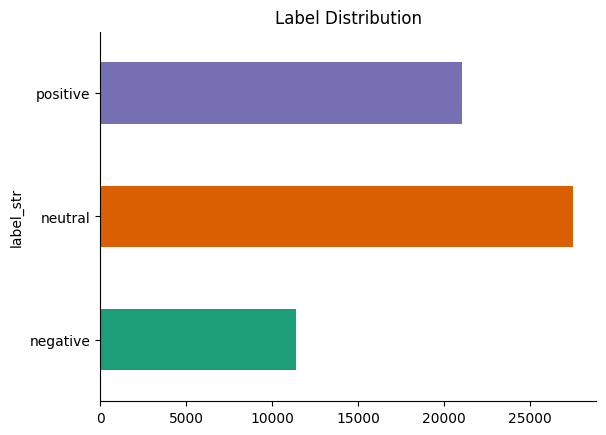

In [5]:
# plot the labels distribution
full_df.groupby('label_str').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title("Label Distribution")
plt.show()

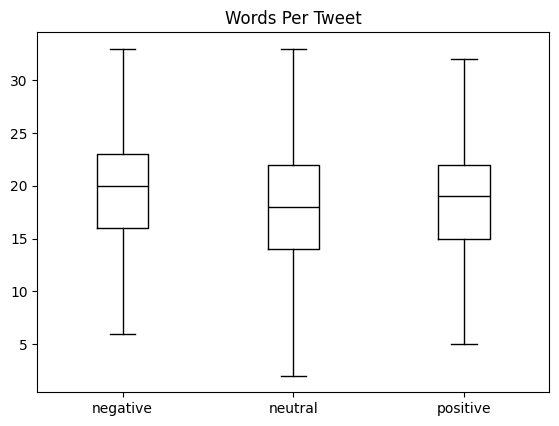

In [6]:
# plot the distribution of words per tweet for each label
full_df["Words Per Tweet"] = full_df["text"].str.split().apply(len)
full_df.boxplot("Words Per Tweet", by="label_str", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## 2. Load the Pre-trained 3-Way Classifier and classify the TWEETEval Data

In [7]:
pip install emoji==0.6.0 # for BERTweet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=642f97336ae2af576033cd599ff7a8757d9dcb9d9f24c7d433b1e4b454cb1182
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji


In [8]:
# load the pretrained dialect classifier (trained BERTweet)
DIALECT_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/models/dialect_classifier"
dialect_model = AutoModelForSequenceClassification.from_pretrained(DIALECT_MODEL_PATH)
dialect_tokenizer = AutoTokenizer.from_pretrained(DIALECT_MODEL_PATH)
dialect_model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [9]:
# define the checkpoint path
CHECKPOINT_PATH = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/cache/tweeteval_dialect_labeled.parquet"
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

# define the dialect mapping
dialect_map = {0: "White", 1: "AAE-no-AAVE", 2: "AAVE"}

# initialized the texts and labels by group
grouped_texts, grouped_labels = {}, {}

In [10]:
# check the the tweets were already classified
if os.path.exists(CHECKPOINT_PATH):
    print("Checkpoint found. Loading classified dataset...")
    dialect_df = pd.read_parquet(CHECKPOINT_PATH)

    # reconstruct grouped_texts and grouped_labels
    print(f"Loaded {len(dialect_df)} tweets with dialect labels.")
    grouped_texts = {group: dialect_df[dialect_df["dialect_label"] == group]["text"].tolist() for group in dialect_df["dialect_label"].unique()}
    grouped_labels = {group: dialect_df[dialect_df["dialect_label"] == group]["label"].tolist() for group in dialect_df["dialect_label"].unique()}

else:
    print("No checkpoint found. Running dialect classification...")

    grouped_texts = {"White": [], "AAE-no-AAVE": [], "AAVE": []}
    grouped_labels = {"White": [], "AAE-no-AAVE": [], "AAVE": []}

    # predict the dialect for the TWEETEval data
    for example in tqdm(full_ds, desc="Classifying Dialect Groups"):
        text = example["text"]
        label = example["label"]

        inputs = dialect_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = dialect_model(**inputs).logits

        predicted_class = torch.argmax(logits, dim=1).item()
        predicted_dialect = dialect_map[predicted_class]

        grouped_texts[predicted_dialect].append(text)
        grouped_labels[predicted_dialect].append(label)

    # flatten grouped_texts and grouped_labels into a DataFrame
    records = []
    for group in grouped_texts:
        texts = grouped_texts[group]
        labels = grouped_labels[group]
        for text, label in zip(texts, labels):
            records.append({"text": text, "label": label, "dialect_label": group})

    # create and save DataFrame
    dialect_df = pd.DataFrame(records)
    dialect_df.to_parquet(CHECKPOINT_PATH)
    dialect_df.to_csv(CHECKPOINT_PATH.replace(".parquet", ".csv"), index=False)

    print(f"Saved checkpoint with {len(dialect_df)} rows to {CHECKPOINT_PATH} and tweeteval_dialect_labeled.csv")

Checkpoint found. Loading classified dataset...
Loaded 59899 tweets with dialect labels.


In [11]:
dialect_df.head()

,text,label,dialect_label
0,"""QT @user In the original draft of the 7th boo...",2,White
1,"""Ben Smith / Smith (concussion) remains out of...",1,White
2,Sorry bout the stream last night I crashed out...,1,White
3,Chase Headley's RBI double in the 8th inning o...,1,White
4,@user Alciato: Bee will invest 150 million in ...,2,White


In [12]:
print("Number of tweets in each group:")
for group, texts in grouped_texts.items():
    print(f"{group}: {len(texts)}")

Number of tweets in each group:
White: 52368
AAE-no-AAVE: 4712
AAVE: 2819


## 3. Sentiment Analysis Across the Groups of Tweets

In [13]:
# list the models under consideration
sentiment_models = {
    "RoBERTa": "cardiffnlp/twitter-roberta-base-sentiment",
    "RoBERTa-Latest": "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "BERTweet": "finiteautomata/bertweet-base-sentiment-analysis"
}

In [14]:
# compute the smallest group size
min_group_size = min(len(grouped_texts["White"]),
                     len(grouped_texts["AAE-no-AAVE"]),
                     len(grouped_texts["AAVE"]))

# initialize the results for full dataset and balanced dataset
full_results, balanced_results = [], []

# initialize prediction arrays
all_full_preds = []       # for confusion matrix (full set)
all_balanced_preds = []   # for confusion matrix (balanced set)

In [15]:
# evaluate each sentiment model on 3 groups of tweets
for model_name, model_path in sentiment_models.items():
    print(f"\nEvaluating sentiment model: {model_name}")
    sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_path)
    sentiment_tokenizer = AutoTokenizer.from_pretrained(model_path)
    sentiment_model.eval()

    for group in ["White", "AAE-no-AAVE", "AAVE"]:
        # ------- Evaluate the results for the full dataset -------
        texts = grouped_texts[group]
        labels = grouped_labels[group] # the actual labels
        preds = []

        for text in tqdm(texts, desc=f"{model_name} on {group} (full)"):
            inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                logits = sentiment_model(**inputs).logits
            pred = torch.argmax(logits, dim=1).item() # predicted labels
            preds.append(pred)

        # record the prediction
        all_full_preds.append({
            "model": model_name,
            "group": group,
            "text": texts,
            "true": labels,
            "pred": preds
        })

        # compute the metric scores
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="macro")
        full_results.append({
            "model": model_name,
            "group": group,
            "accuracy": acc,
            "f1_score": f1,
            "mode": "full"
        })
        # ---------------------------------------------------------

        # ----- Evaluate the results for the balanced dataset -----
        indices = random.sample(range(len(texts)), min_group_size)
        texts_balanced = [texts[i] for i in indices]
        labels_balanced = [labels[i] for i in indices] # the actual labels
        preds_balanced = []

        for text in tqdm(texts_balanced, desc=f"{model_name} on {group} (balanced)"):
            inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
            with torch.no_grad():
                logits = sentiment_model(**inputs).logits
            pred = torch.argmax(logits, dim=1).item() # predicted labels
            preds_balanced.append(pred)

        # record the prediction
        all_balanced_preds.append({
            "model": model_name,
            "group": group,
            "text": texts_balanced,
            "true": labels_balanced,
            "pred": preds_balanced
        })

        # compute the metric scores
        acc_balanced = accuracy_score(labels_balanced, preds_balanced)
        f1_balanced = f1_score(labels_balanced, preds_balanced, average="macro")
        balanced_results.append({
            "model": model_name,
            "group": group,
            "accuracy": acc_balanced,
            "f1_score": f1_balanced,
            "mode": "balanced"
        })
        # ---------------------------------------------------------


Evaluating sentiment model: RoBERTa


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

RoBERTa on White (full):   0%|          | 0/52368 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RoBERTa on White (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

RoBERTa on AAE-no-AAVE (full):   0%|          | 0/4712 [00:00<?, ?it/s]

RoBERTa on AAE-no-AAVE (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

RoBERTa on AAVE (full):   0%|          | 0/2819 [00:00<?, ?it/s]

RoBERTa on AAVE (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]


Evaluating sentiment model: RoBERTa-Latest


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

RoBERTa-Latest on White (full):   0%|          | 0/52368 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RoBERTa-Latest on White (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

RoBERTa-Latest on AAE-no-AAVE (full):   0%|          | 0/4712 [00:00<?, ?it/s]

RoBERTa-Latest on AAE-no-AAVE (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

RoBERTa-Latest on AAVE (full):   0%|          | 0/2819 [00:00<?, ?it/s]

RoBERTa-Latest on AAVE (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]


Evaluating sentiment model: BERTweet


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

BERTweet on White (full):   0%|          | 0/52368 [00:00<?, ?it/s]

BERTweet on White (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

BERTweet on AAE-no-AAVE (full):   0%|          | 0/4712 [00:00<?, ?it/s]

BERTweet on AAE-no-AAVE (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

BERTweet on AAVE (full):   0%|          | 0/2819 [00:00<?, ?it/s]

BERTweet on AAVE (balanced):   0%|          | 0/2819 [00:00<?, ?it/s]

In [16]:
results_full_df = pd.DataFrame(full_results)
results_balanced_df = pd.DataFrame(balanced_results)
results_all_df = pd.DataFrame(full_results + balanced_results)

In [17]:
results_all_df

,model,group,accuracy,f1_score,mode
0,RoBERTa,White,0.808815,0.807437,full
1,RoBERTa,AAE-no-AAVE,0.795628,0.787915,full
2,RoBERTa,AAVE,0.789287,0.789720,full
3,RoBERTa-Latest,White,0.768141,0.766732,full
4,RoBERTa-Latest,AAE-no-AAVE,0.755306,0.746919,full
5,RoBERTa-Latest,AAVE,0.737850,0.739475,full
6,BERTweet,White,0.818611,0.817249,full
7,BERTweet,AAE-no-AAVE,0.824915,0.820304,full
8,BERTweet,AAVE,0.821923,0.823498,full
9,RoBERTa,White,0.815537,0.815987,balanced


In [35]:
# helper function to convert predictions to flat dataframe (with tweet text)
def convert_to_dataframe(predictions_list, mode):
    rows = []
    for entry in predictions_list:
        model = entry["model"]
        group = entry["group"]
        for tweet, true_label, pred_label in zip(entry["text"], entry["true"], entry["pred"]):
            rows.append({
                "model": model,
                "group": group,
                "mode": mode,
                "text": tweet,
                "true_label": true_label,
                "pred_label": pred_label
            })
    return pd.DataFrame(rows)

In [36]:
preds_full_df = convert_to_dataframe(all_full_preds, mode="full")
preds_balanced_df = convert_to_dataframe(all_balanced_preds, mode="balanced")

In [37]:
preds_full_df.head(10)

,model,group,mode,text,true_label,pred_label
0,RoBERTa,White,full,"""QT @user In the original draft of the 7th boo...",2,2
1,RoBERTa,White,full,"""Ben Smith / Smith (concussion) remains out of...",1,1
2,RoBERTa,White,full,Sorry bout the stream last night I crashed out...,1,1
3,RoBERTa,White,full,Chase Headley's RBI double in the 8th inning o...,1,1
4,RoBERTa,White,full,@user Alciato: Bee will invest 150 million in ...,2,1
5,RoBERTa,White,full,So disappointed in wwe summerslam! I want to s...,0,0
6,RoBERTa,White,full,@user @user CENA & AJ sitting in a tree K-I-S-...,1,1
7,RoBERTa,White,full,@user Well said on HMW. Can you now address wh...,1,1
8,RoBERTa,White,full,Just said hello to Dennis Kucinich as he walke...,1,2
9,RoBERTa,White,full,Super excited for homecoming Saturday with Mon...,2,2


In [38]:
preds_balanced_df.head(10)

,model,group,mode,text,true_label,pred_label
0,RoBERTa,White,balanced,U of #Memphis student Nadine Taha @user justif...,1,0
1,RoBERTa,White,balanced,"GRASSROOTS FUROR OVER#ROMNEY ""ACKNOWLEDGED.""DA...",2,1
2,RoBERTa,White,balanced,We need some Universal Robots to take care of ...,0,0
3,RoBERTa,White,balanced,"Win a NOKIA LUMIA courtesy of @user tomorrow, ...",1,2
4,RoBERTa,White,balanced,Now playing Foo Fighters - Cold Day in the Sun,2,1
5,RoBERTa,White,balanced,@user @user @user Jill's auditioning for a luc...,1,1
6,RoBERTa,White,balanced,Oomf is in for it tomorrow I just can't wait I...,2,2
7,RoBERTa,White,balanced,@user I get in around noon!!! And I\u2019m com...,1,2
8,RoBERTa,White,balanced,I may have just mentally assembled the most in...,1,1
9,RoBERTa,White,balanced,Hey @user fuck you. I don't have Internet unti...,0,0


In [22]:
# define the path to save the data
RESULTS_DIR = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/results/sentiment_analysis"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [39]:
# helper method to plot the confusion matrix of the predictions
def plot_confusion_matrices(results, title_prefix=""):
    for entry in results:
        y_true = entry["true"]
        y_pred = entry["pred"]
        model = entry["model"]
        group = entry["group"]

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format='d')
        plt.title(f"{title_prefix} {model} - {group}")
        filename = f"{title_prefix.strip().replace(' ', '_')}_{model}_{group}_confusion_matrix.png"
        plt.savefig(os.path.join(RESULTS_DIR, filename), bbox_inches="tight")
        plt.show()
        plt.close()

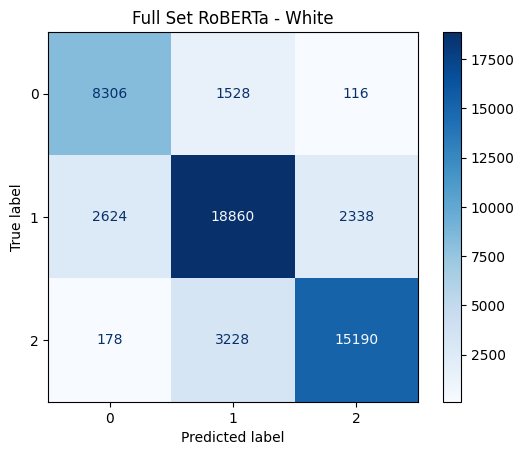

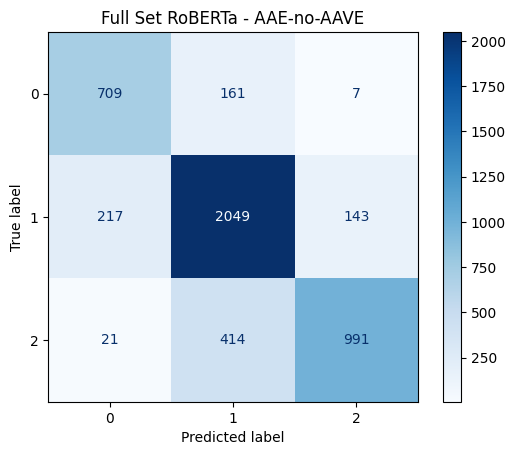

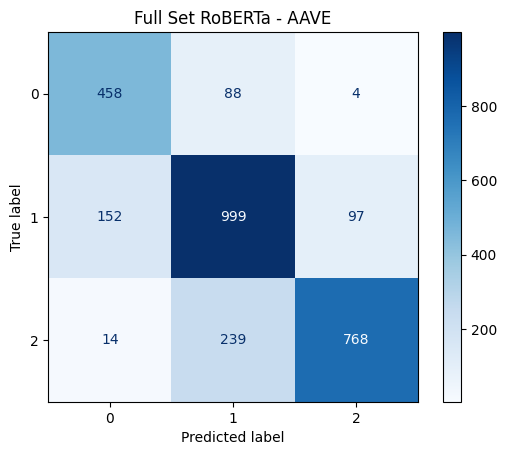

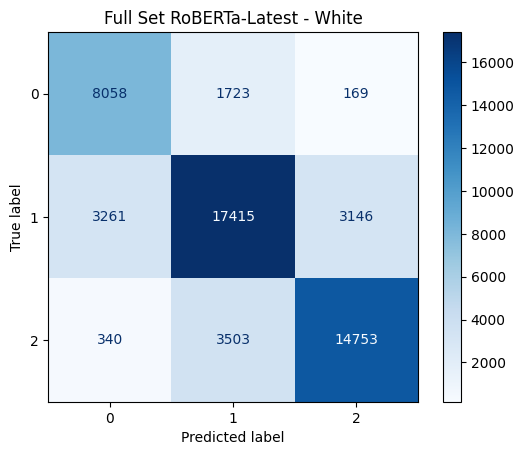

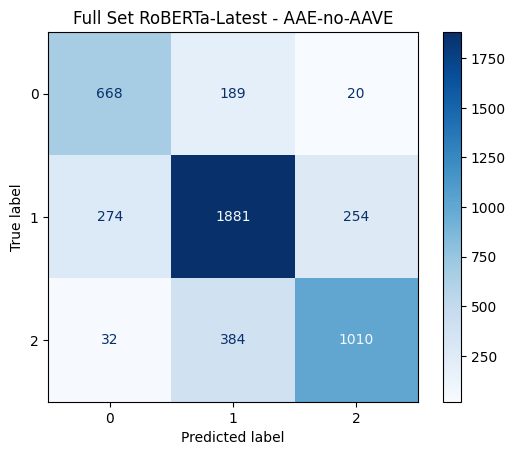

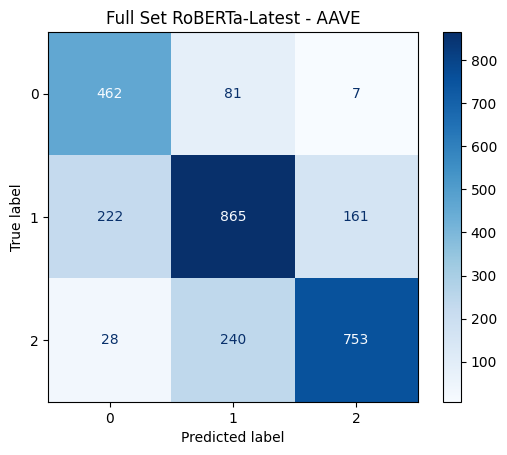

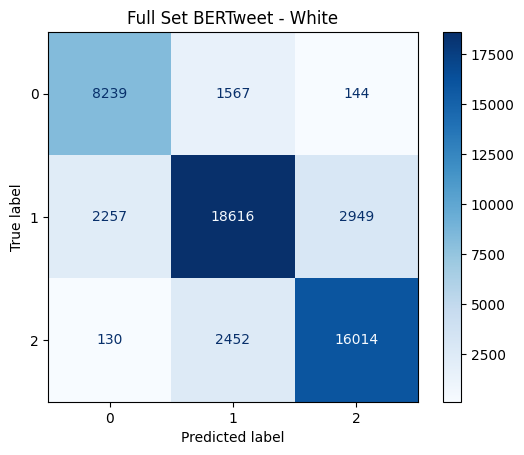

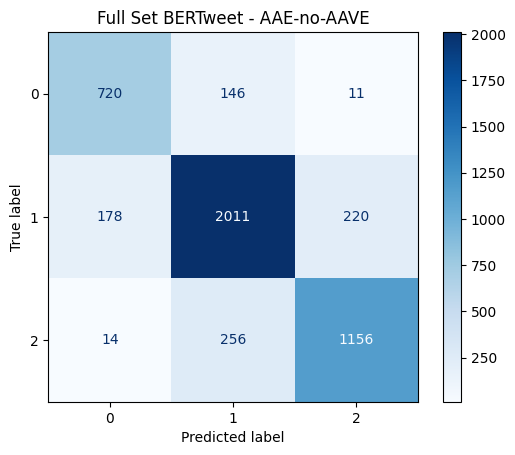

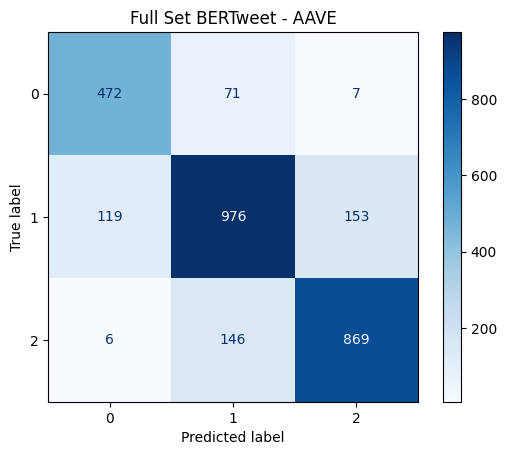

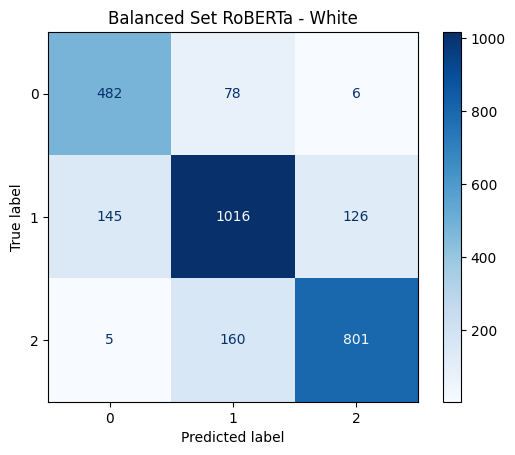

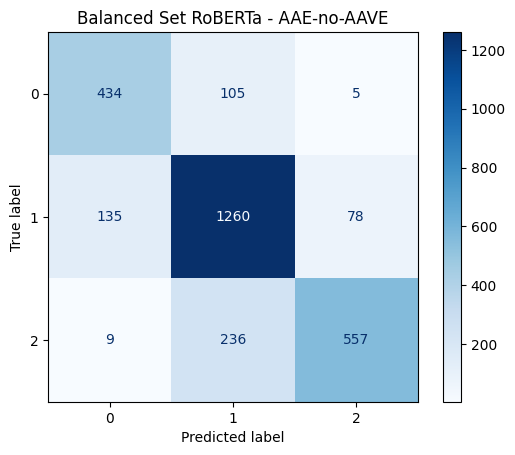

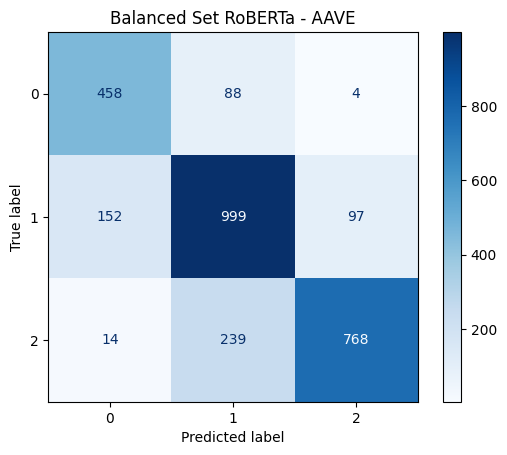

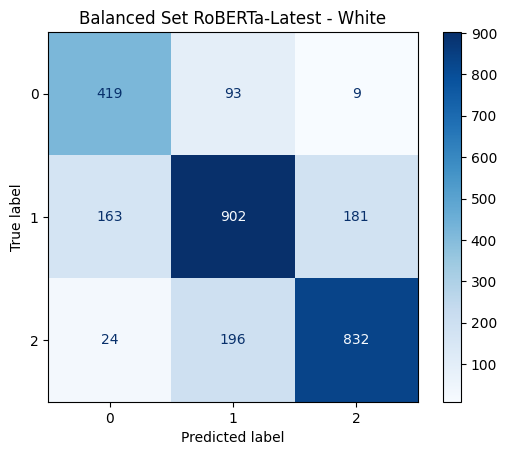

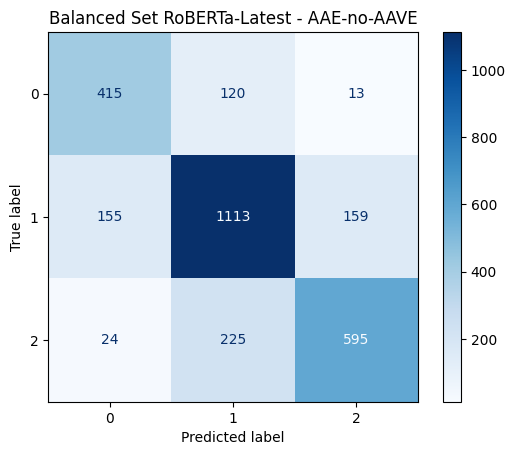

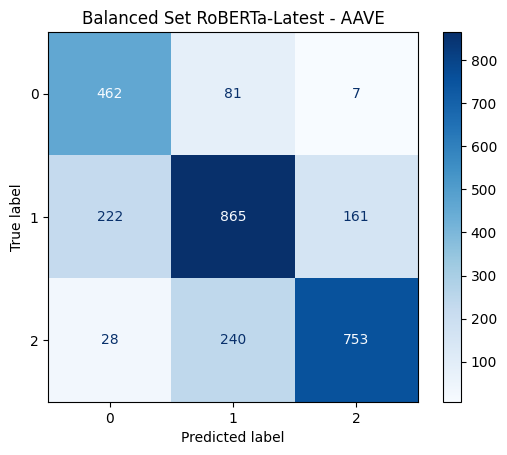

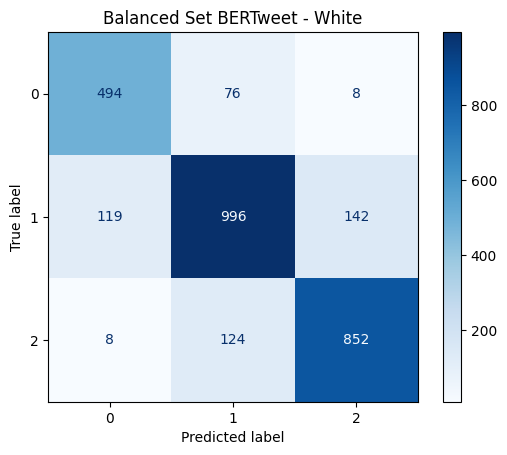

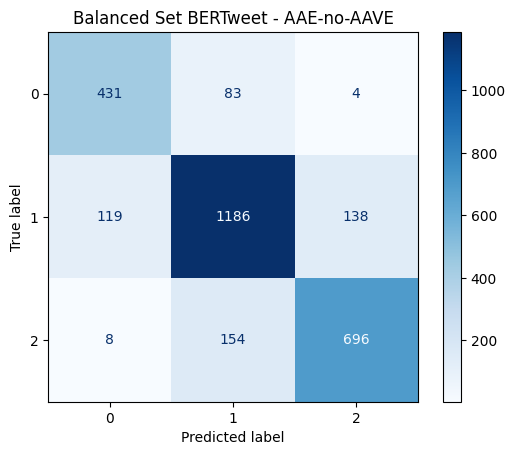

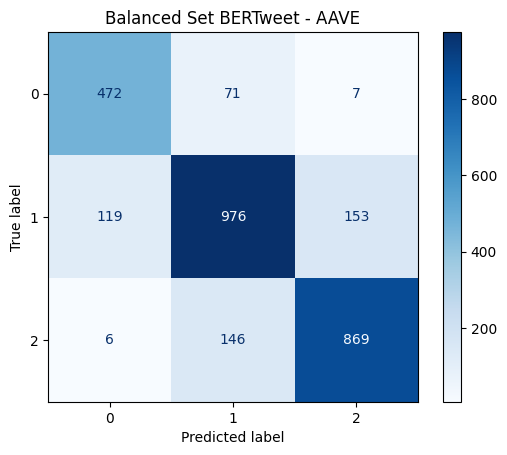

In [40]:
# plot the confusion matrices for full and balanced sets respectively
plot_confusion_matrices(all_full_preds, title_prefix="Full Set")
plot_confusion_matrices(all_balanced_preds, title_prefix="Balanced Set")

In [41]:
# helper method to plot the results for each dialect group
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="group", y=metric, hue="model")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("Dialect Group")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/{metric}_{df['mode'].iloc[0]}.png")
    plt.show()
    plt.close()

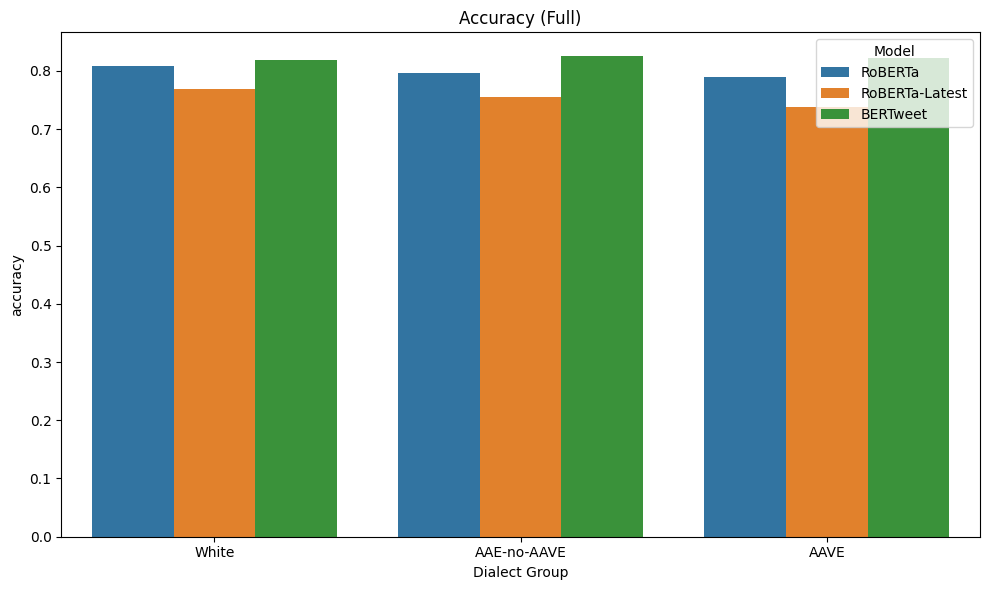

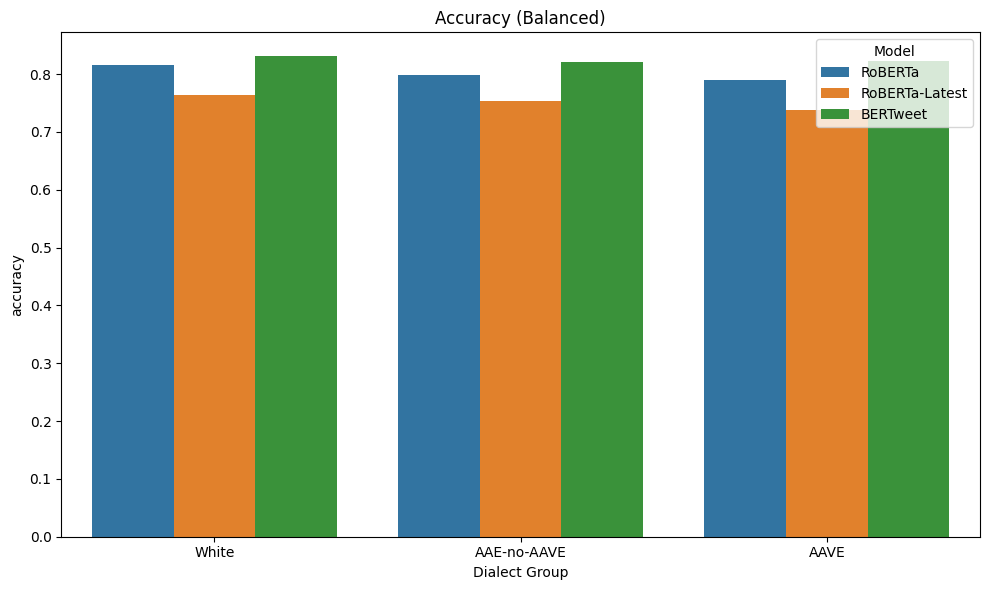

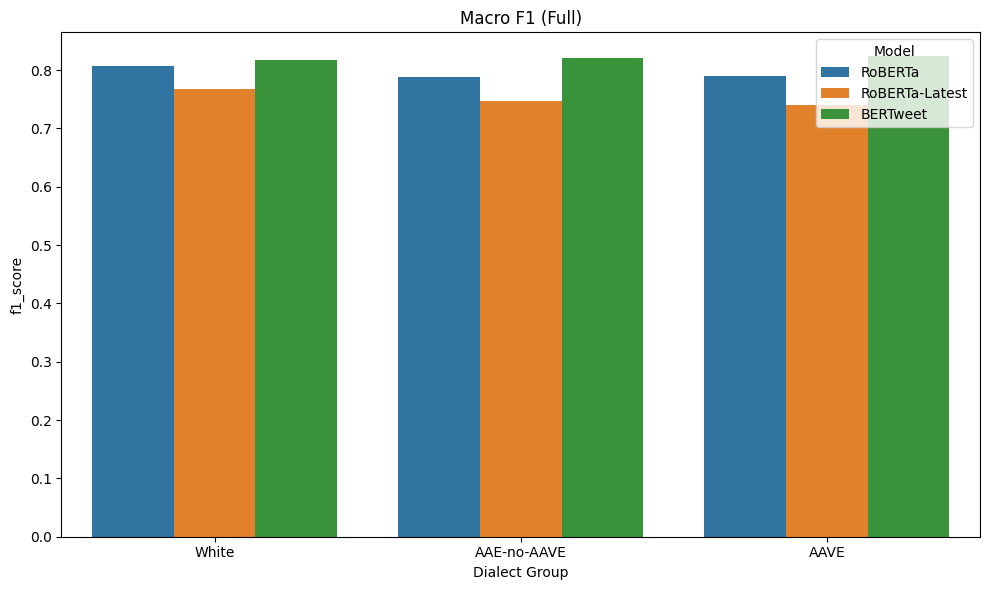

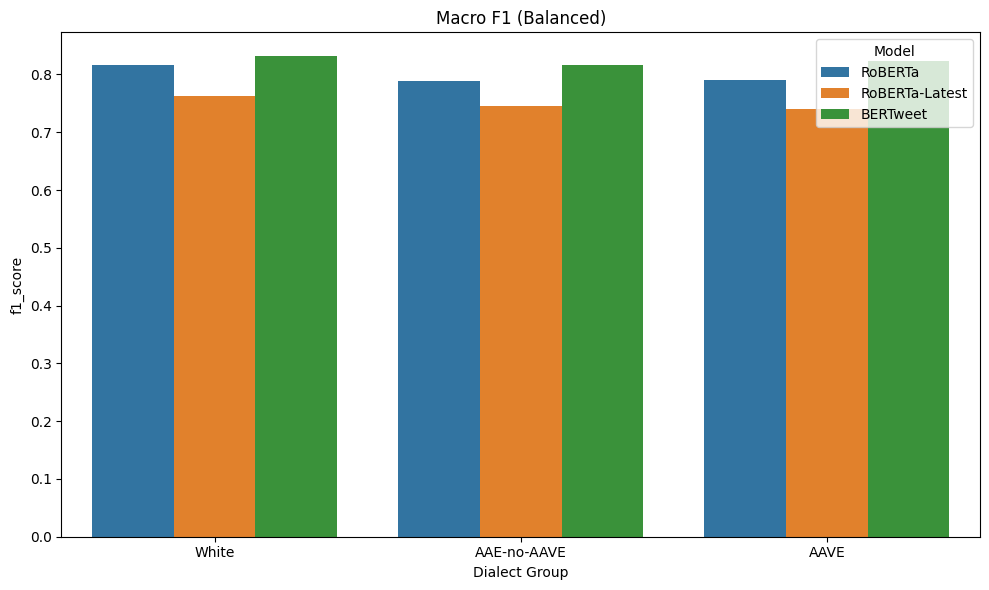

In [42]:
# plot the results
plot_metric(results_all_df[results_all_df["mode"] == "full"], "accuracy", "Accuracy (Full)")
plot_metric(results_all_df[results_all_df["mode"] == "balanced"], "accuracy", "Accuracy (Balanced)")
plot_metric(results_all_df[results_all_df["mode"] == "full"], "f1_score", "Macro F1 (Full)")
plot_metric(results_all_df[results_all_df["mode"] == "balanced"], "f1_score", "Macro F1 (Balanced)")

In [43]:
# save the results and predictions
results_full_df.to_csv(f"{RESULTS_DIR}/sentiment_bias_results_full.csv", index=False)
results_balanced_df.to_csv(f"{RESULTS_DIR}/sentiment_bias_results_balanced.csv", index=False)
results_all_df.to_csv(f"{RESULTS_DIR}/sentiment_bias_results_all.csv", index=False)
preds_full_df.to_csv(f"{RESULTS_DIR}/sentiment_bias_predictions_full.csv", index=False)
preds_balanced_df.to_csv(f"{RESULTS_DIR}/sentiment_bias_predictions_balanced.csv", index=False)
print(f"\nSentiment bias analysis complete. Results saved to {RESULTS_DIR}")


Sentiment bias analysis complete. Results saved to /content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/results/sentiment_analysis
